In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
   

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-customer-reviews/Reviews.csv
/kaggle/input/amazon-customer-reviews/database.sqlite


In [5]:
import numpy as np
import pandas as pd 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
df = pd.read_csv("/kaggle/input/amazon-customer-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Data Pre-processing

In [8]:
# if helpfulness denominator is greater than '0', perform operation, otherwise append '-1'
# this will give an array ranging between '-1' to '+1'
df['Helpful %'] = np.where(df['HelpfulnessDenominator']>0, df['HelpfulnessNumerator']/df['HelpfulnessDenominator'], -1)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0


In [9]:
# convert them into bins
df['Upvote %'] = pd.cut(df['Helpful %'], bins=[-1,0,0.2,0.4,0.6,0.8,1], labels=['Empty', '0-20%','20-40%', '40-60%', '60-80%', '80-100%'])
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,Upvote %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


## Exploratory Data Analysis

In [10]:
# analyse the upvotes % for different scores
df.groupby(['Score', 'Upvote %']).agg('count')

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Score Upvote %                                                                 
1     Empty       8060       8060    8060         8060                  8060   
      0-20%       2338       2338    2338         2338                  2338   
      20-40%      4649       4649    4649         4649                  4649   
      40-60%      6586       6586    6586         6586                  6586   
      60-80%      5838       5838    5838         5836                  5838   
      80-100%    12531      12531   12531        12531                 12531   
2     Empty       4234       4234    4234         4234                  4234   
      0-20%        762        762     762          762                   762   
      20-40%      1618       1618    1618         1618                  1618   
      40-60%      3051       3051    3051         3051                  3051   
      60-80%      2486       2486    2486         2486                  2486   
      80-100%     7014       7014    7014         7014                  7014   
3     Empty       5062       5062    5062         5062                  5062   
      0-20%        474        474     474          474                   474   
      20-40%      1506       1506    1506         1506                  1506   
      40-60%      3384       3384    3384         3384                  3384   
      60-80%      2754       2754    2754         2754                  2754   
      80-100%    11037      11037   11037        11037                 11037   
4     Empty       4780       4780    4780         4780                  4780   
      0-20%        116        116     116          116                   116   
      20-40%       909        909     909          909                   909   
      40-60%      3185       3185    3185         3185                  3185   
      60-80%      2941       2941    2941         2941                  2941   
      80-100%    26707      26707   26707        26707                 26707   
5     Empty      11638      11638   11638        11638                 11638   
      0-20%        432        432     432          432                   432   
      20-40%      2275       2275    2275         2275                  2275   
      40-60%     10312      10312   10312        10312                 10312   
      60-80%     11060      11060   11060        11060                 11060   
      80-100%   140661     140661  140661       140659                140661   

                HelpfulnessDenominator    Time  Summary    Text  Helpful %  
Score Upvote %                                                              
1     Empty                       8060    8060     8060    8060       8060  
      0-20%                       2338    2338     2338    2338       2338  
      20-40%                      4649    4649     4649    4649       4649  
      40-60%                      6586    6586     6586    6586       6586  
      60-80%                      5838    5838     5838    5838       5838  
      80-100%                    12531   12531    12531   12531      12531  
2     Empty                       4234    4234     4234    4234       4234  
      0-20%                        762     762      737     762        762  
      20-40%                      1618    1618     1618    1618       1618  
      40-60%                      3051    3051     3051    3051       3051  
      60-80%                      2486    2486     2486    2486       2486  
      80-100%                     7014    7014     7014    7014       7014  
3     Empty                       5062    5062     5062    5062       5062  
      0-20%                        474     474      474     474        474  
      20-40%                      1506    1506     1506    1506       1506  
      40-60%                      3384    3384     3384    3384       3384  
      60-80%                      2754    2754     2754    2754       275

In [11]:
df_s = df.groupby(['Score', 'Upvote %']).agg({'Id':'count'}).reset_index()
df_s

,Score,Upvote %,Id
0,1,Empty,8060
1,1,0-20%,2338
2,1,20-40%,4649
3,1,40-60%,6586
4,1,60-80%,5838
5,1,80-100%,12531
6,2,Empty,4234
7,2,0-20%,762
8,2,20-40%,1618
9,2,40-60%,3051


In [12]:
# create pivot table
pivot = df_s.pivot(index='Upvote %', columns='Score')
pivot

Id                            
Score         1     2      3      4       5
Upvote %                                   
Empty      8060  4234   5062   4780   11638
0-20%      2338   762    474    116     432
20-40%     4649  1618   1506    909    2275
40-60%     6586  3051   3384   3185   10312
60-80%     5838  2486   2754   2941   11060
80-100%   12531  7014  11037  26707  140661

<AxesSubplot:xlabel='None-Score', ylabel='Upvote %'>

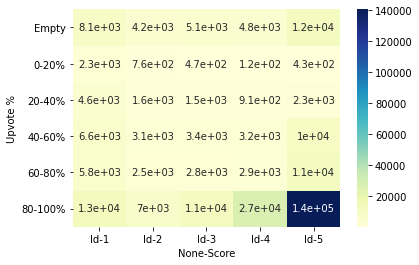

In [13]:
# create heatmap
sns.heatmap(pivot, annot=True, cmap='YlGnBu')

- More than half of reviews are with '0' score
- Many people agree with score '5'

## Bag-of-Words  
### Manual Approach

In [14]:
# apply BOW
df['Score'].unique()

array([5, 1, 4, 2, 3])

In [15]:
# when score is '3' means 'Neutral', so filter it out
df2 = df[df['Score'] != 3]

In [16]:
X = df2['Text']
df2['Score'].unique()

array([5, 1, 4, 2])

In [17]:
# create a dictionary for score with '0' and '1'
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df2['Score'].map(y_dict)

In [18]:
# convert text
c = CountVectorizer(stop_words='english')
X_c = c.fit_transform(X)

In [19]:
X_c.shape # no. of features increased after applying CountVectorizer

(525814, 114969)

In [20]:
# check model accuracy
X_train, X_test, y_train, y_test = train_test_split(X_c, y)

In [21]:
X_train.shape

(394360, 114969)

In [22]:
log_reg = LogisticRegression(solver='liblinear')
model = log_reg.fit(X_train, y_train)

In [23]:
model.score(X_test, y_test)

0.9382369498075372

In [24]:
# fetch top 20 positive and  top 20 negative words from the model
w = c.get_feature_names()
# w

In [25]:
coef = model.coef_.tolist()[0]
# coef

In [26]:
coef_df = pd.DataFrame({'Word': w, 'Coefficient': coef})
coef_df

,Word,Coefficient
0,00,-0.321696
1,000,0.033803
2,0000,1.283580
3,000001,-0.002263
4,00001,-0.035207
...,...,...
114964,çaykur,0.002749
114965,çelem,-0.175529
114966,être,0.019347
114967,île,0.000000


In [27]:
coef_df = coef_df.sort_values(['Coefficient', 'Word'], ascending=False)

In [28]:
# top 20 positive words
coef_df.head(20)

,Word,Coefficient
27198,chedder,3.326038
41175,emeraldforest,3.104412
80600,pleasantly,3.005365
40135,easiest,2.714490
55029,hooked,2.667758
52502,hahaha,2.580569
94680,skewed,2.471364
96145,solving,2.379843
5865,addicting,2.324388
20268,bertie,2.295731


In [29]:
# top 20 nagative words
coef_df.tail(20)

,Word,Coefficient
76621,oversalted,-2.506047
88945,ripoff,-2.517959
60312,juiciest,-2.534662
41118,embarrassed,-2.552611
56229,ick,-2.586202
70803,mountian,-2.586456
35220,defeats,-2.627363
23580,budda,-2.665318
103002,textual,-2.704694
24949,cancelled,-2.705202


### Automated Approach

In [30]:
def text_fit(X, y, nlp_model, ml_model, coef_show=1):
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    model = ml_model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(acc)
    
    if coef_show == 1:    
        w = c.get_feature_names()
        coef = model.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Word': w, 'Coefficient': coef})
        coef_df = coef_df.sort_values(['Coefficient', 'Word'], ascending=False)
        print('\n')
        print('Top 20 Positive Words')
        print(coef_df.head(20))
        print('\n')
        print('Top 20 Negative Words')
        print(coef_df.tail(20))

In [31]:
# nlp model
c = CountVectorizer(stop_words='english')

# ml model
log_reg = LogisticRegression(solver='liblinear')

In [32]:
text_fit(X, y, c, log_reg)

features: 114969
0.9386553471176229


Top 20 Positive Words
                 Word  Coefficient
80600      pleasantly     3.063312
5865        addicting     2.530014
53610        heartier     2.414197
94680          skewed     2.323233
20268          bertie     2.305163
39072        downside     2.288063
40135         easiest     2.269207
96145         solving     2.239534
20924         biscoff     2.170458
53585           hears     2.164940
81327        popcorns     2.158015
55029          hooked     2.116181
41175   emeraldforest     2.088623
73164        noisette     2.076706
113138        worries     2.052360
102058         tastey     2.005788
58320          intend     1.971372
19488            beat     1.962757
63152            leap     1.962195
38394          divine     1.942246


Top 20 Negative Words
                  Word  Coefficient
34989        deceptive    -2.432431
106852    unacceptable    -2.446812
35220          defeats    -2.474137
2570           3095826    -2.489893
4

In [33]:
def predict(X, y, nlp_model, ml_model):
    X_c = nlp_model.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    model = ml_model.fit(X_train, y_train)
    pred = model.predict(X_test)
    cm = confusion_matrix(pred, y_test)
    print(cm)
    acc = accuracy_score(pred, y_test)
    print(acc)   

In [34]:
c = CountVectorizer()
lr = LogisticRegression(solver='liblinear')

predict(X, y, c, lr)

[[ 15650   2651]
 [  4735 108418]]
0.9438130448674061


## TF-IDF

In [35]:
c = CountVectorizer()
text_fit(X, y, c, DummyClassifier(), 0)

features: 115282
0.7371856314756493


In [36]:
tfidf = TfidfVectorizer(stop_words='english')
lr = LogisticRegression(solver='liblinear')

text_fit(X, y, tfidf, lr, 0)

features: 114969
0.9347604485219164


In [37]:
predict(X, y, tfidf, lr)

[[ 14268   2283]
 [  6372 108531]]
0.934159477840157


## Data preparation for Modeling

In [38]:
# data preparation for predicting the upvotes, as high number of users with score '5'
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,Upvote %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


In [39]:
data = df[df['Score'] == 5]
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,Upvote %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,-1.0,NaN
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,-1.0,NaN
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,80-100%


In [40]:
data['Upvote %'].unique()

['80-100%', NaN, '60-80%', 'Empty', '40-60%', '20-40%', '0-20%']
Categories (6, object): ['Empty' < '0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

In [41]:
# get rid of neutral and empty votes
data2 = data[data['Upvote %'].isin(['80-100%','60-80%','20-40%', '0-20%'])]
data2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,Upvote %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,80-100%
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,80-100%
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,80-100%
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,60-80%


In [42]:
# seperate independent to give it to model
X = data2['Text']

In [43]:
data2['Upvote %'].unique()

['80-100%', '60-80%', '20-40%', '0-20%']
Categories (4, object): ['0-20%' < '20-40%' < '60-80%' < '80-100%']

In [44]:
y_dict = {'80-100%':1, '60-80%':1, '20-40%':0, '0-20%':0}
y = data2['Upvote %'].map(y_dict)

## Over Sampling - handle Imbalanced data

In [47]:
# if dataset is imbalanced,we can use -
# Undersampling - same ratio of data for both class, but data loss,
# Oversampling - add extra data points to make same ratio,
# SMOTE TOMEK, 
# Ensemble techniques i.e., Random Forest - multiple decision trees

In [48]:
# check value counts to gain insight if data is 'imbalanced'
y.value_counts()

1.0    151721
0.0      2707
Name: Upvote %, dtype: int64

In [49]:
os = RandomOverSampler()

X_train_res, y_train_res = os.fit_resample(X_c, y)

In [50]:
X_train_res.shape

(303442, 67507)

In [51]:
y_train_res.shape

(303442,)

In [52]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({1.0: 151721, 0.0: 2707})
Resampled dataset shape Counter({1.0: 151721, 0.0: 151721})


## Cross-Validation (GridSeachCV)

In [53]:
log_class = LogisticRegression(solver='liblinear')

In [54]:
grid = {'C':10.0**np.arange(-2,3), 'penalty':['l1','l2']}

In [55]:
clf = GridSearchCV(estimator=log_class,
                  param_grid = grid,
                  cv=5,
                  n_jobs=-1, # use all resources of CPU
                  scoring='f1_macro')

In [56]:
clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y)

In [58]:
pred = clf.predict(X_test)

In [59]:
confusion_matrix(y_test, pred)

array([[  712,     0],
       [   12, 37883]])

In [60]:
accuracy_score(y_test, pred)

0.9996891755381149